# Laboratorio 1
## MDS7203 - Modelos Generativos Profundos
#### Profesor: Felipe Tobar
#### Auxiliares: Cristóbal Alcázar, Camilo Carvajal Reyes
#### Estudiante: Sebastián Sanhueza
#### Primavera 2023

## P1 - Sampling

In [1]:
# Librerias

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
from scipy.stats import norm
from scipy.stats import uniform

### a)

Se estableció una variable $\mu$, que sigue una distribución Half-normal con una media de 0 y una varianza de 10. A partir de esta variable, se tomó una muestra aleatoria para su uso posterior en la parte b de esta pregunta. La muestra resultante arrojó un valor aproximado de $\mu \approx 0.7221$, el cual se representa visualmente en relación con la distribución Half-normal completa en el gráfico ubicado en la parte inferior.

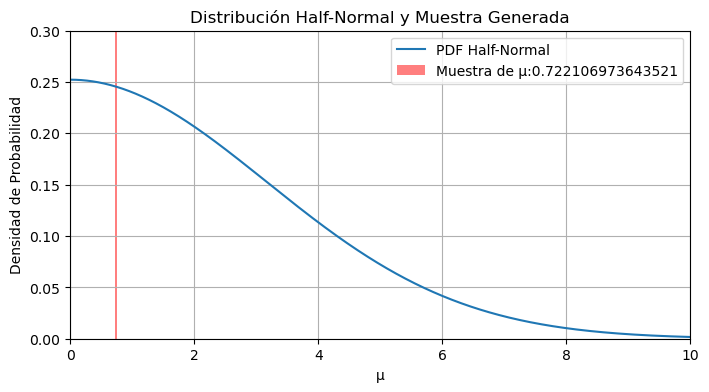

In [2]:
# Fijamos la semilla
np.random.seed(206684402)

# Parámetros de la distribución
media = 0
varianza = 10

# Generamos un rango de valores para mu
mu_values = np.linspace(0, 10, 1000)

# Calculamos la PDF para cada valor de mu a partir de una distribucion Half-normal
mu_pdf = halfnorm.pdf(mu_values, scale=np.sqrt(varianza), loc=media)

# Generamos una muestra de mu
mu_sample = halfnorm.rvs(scale=np.sqrt(varianza), loc=media)

# Visualizamos la PDF y la muestra
plt.figure(figsize=(8, 4))
plt.plot(mu_values, mu_pdf, label='PDF Half-Normal')
plt.hist(mu_sample, bins=30, density=True, alpha=0.5, color='red', label=f'Muestra de \u03BC:{mu_sample}')
plt.xlim(0, 10)  
plt.ylim(0, 0.3)
plt.xlabel('\u03BC')
plt.ylabel('Densidad de Probabilidad')
plt.title('Distribución Half-Normal y Muestra Generada')
plt.legend()
plt.grid(True)

# Muestra el gráfico
plt.show()

### b)

A partir de la muestra de la variable $\mu$ obtenida en la etapa anterior, se generaron un total de $n = 1000$ muestras $x_{i}$, las cuales siguen una distribución Normal con una media igual al valor de la muestra de $\mu \approx 0.7221$ y una varianza de 5. Puede observarse la representación gráfica de estas muestras en el histograma situado en la parte inferior.

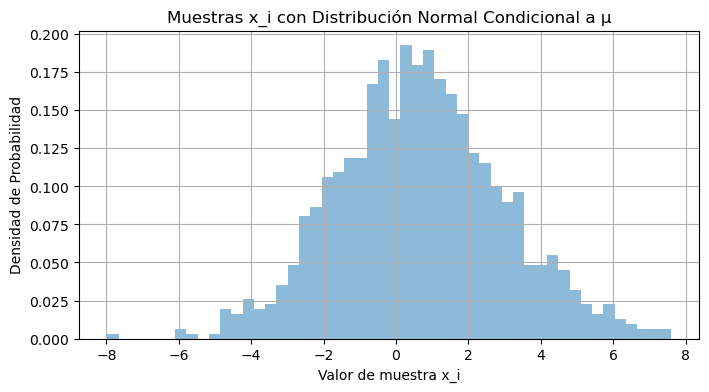

In [3]:
# Fijamos la semilla
np.random.seed(206684402)

# Parámetros de la distribución Normal condicional
varianza_xi = 5
n_samples = 1000

# Generamos n muestras x_i a partir de la distribución Normal condicional
xi_samples = [norm.rvs(loc=mu_sample, scale=np.sqrt(varianza_xi)) for _ in range(n_samples)]

# Grafica las muestras x_i
plt.figure(figsize=(8, 4))
plt.hist(xi_samples, bins=50, density=True, alpha=0.5)
plt.xlabel('Valor de muestra x_i')
plt.ylabel('Densidad de Probabilidad')
plt.title('Muestras x_i con Distribución Normal Condicional a \u03BC')
plt.grid(True)

# # Muestra el gráfico
plt.show()


### c)
Para expresar $p(\mu|x_{1},...,x_{n})$ se utilizará el Teorema de Bayes, tal que:
$$p(\mu|x_{1},...,x_{n}) = \frac{p(x_{1},...,x_{n}|\mu)p(\mu)}{p(x_{1},...,x_{n})}$$
Además, en general se puede considerar que el denominador $p(x_{1},...,x_{n})$ es bastante complicado para computar junto con que las muestra $x_{i}$ son i.i.d. Entonces la distribución a posteriori se puede expresar de la siguiente forma:
$$p(\mu|x_{1},...,x_{n}) \propto p(x_{1},...,x_{n}|\mu)p(\mu) = \prod_{i=1}^{n} p(x_{i}|\mu)p(\mu)$$
donde el producto $\prod_{i=1}^{n} p(x_{i}|\mu)$ es la función likelihood para el caso en que las muestras son i.i.d, las cuales ya se conoce que ditribuyen de forma Normal, mientras que $p(\mu)$ es la distribución a priori, la cual representa el conocimiento previo que se tiene del parámetro $\mu$.

### d)
Se ha diseñado un algoritmo de Metropolis-Hasting, en el que se optó por trabajar con la transformación logarítmica de la función de likelihood y prior. Esta elección se hizo para evitar problemas de divisiones por cero, ya que la función de likelihood, al ser una multiplicación de múltiples valores de probabilidad, tiende a ser muy cercana a cero, lo que puede ocasionar dificultades en el cómputo en Python. Al aplicar la transformación logarítmica, la función se convierte en una suma de valores más manejables.

En cuanto a la distribución a priori, se consideró que la única información previa disponible sobre el parámetro $\mu$ es que debe ser mayor que cero. Por lo tanto, se definió un enfoque en el que se asigna un valor infinito negativo como prior para valores negativos de $\mu$, lo que implica que estos valores serán rechazados en el método de Metropolis-Hasting. Por otro lado, para valores positivos de $\mu$, se asigna un prior igual a cero, lo que es equivalente a asignar una probabilidad de 1 a estos valores.

Por último, como distribución auxiliar, se consideró una distribución uniforme. A partir de esta se generan las muestras propuestas para ser evaluadas mediante el algoritmo de Metropolis-Hasting. 

In [4]:
# Función de logaritmo de la distribución prior
def log_prior(u):
    # Se asume que la información previa es solamente que los valores de mu tienen que se positivos
    if u<0:
        return -np.inf # Si sale un mu negativo se asigna un valor negativo infinito para que se rechace
    return 0 # Se le asigna probabilidad 1 para todos los valores positivos

# Función de logaritmo de la distribución likelihood
def log_likelihood(u, samples):
    # Al aplicar la transformación logarítmica al pitatoria se convierte en una sumatoria de 
    # distribuciones normales
    return np.sum(np.log(norm.pdf(samples, scale=np.sqrt(5), loc=u)))

# Se define la función que realiza el algoritmo de Metropolis-Hasting
def metropolis_hasting(likelihood, prior, sample_init, num_samples, data, rango_propuesto):
    
    # Se registran los samples que fueron aceptados y rechazados
    accepted_samples = [sample_init] # Se asigna el sample inicial como el primer aceptado
    rejected_samples = [] 
    
    for i in range(num_samples):
        # Se genera un sample de mu propuesto a partir de una distribución uniforme
        u_proposed = accepted_samples[-1] + rango_propuesto*np.random.uniform(low=-1, high=1)
        #u_proposed = np.random.normal(scale=rango_propuesto, loc=accepted_samples[-1])
        
        # Se genera el ratio de aceptación aplicando la transformación logarítmica
        ratio_acceptance = (likelihood(u_proposed, data) + prior(u_proposed))-(likelihood(accepted_samples[-1], data) + prior(accepted_samples[-1]))
        
        # Si el valor del ratio es mayor a un valor aleatorio entre 0 y 1 se acepta el sample
        if np.log(np.random.rand()) < ratio_acceptance:
            accepted_samples.append(u_proposed) # Se registra en la lista de samples aceptados
        # Si el valor del ratio no es mayor al valor aleatorio se rechaza el sample
        else:
            accepted_samples.append(accepted_samples[-1]) # Se registra el sample actual nuevamente
            rejected_samples.append(u_proposed) # Se registra el sample rechazado en la lista de samples rechazados
            
    return accepted_samples, rejected_samples  

Para implementar el algoritmo de Metropolis-Hasting, se tomó como punto de partida una muestra inicial de $0.1$. Esta elección se hizo para que el algoritmo comience a explorar valores cercanos a la distribución real desde el principio.

Además, se estableció un rango de $0.1$ para la distribución auxiliar. Este rango se definió de manera que las nuevas muestras propuestas estén en una vecindad estrecha alrededor de la muestra actual. Esto ayuda a que el algoritmo se mueva de manera eficiente en el espacio de búsqueda de las muestras.

Por último, se configuró el algoritmo para generar un total de $50,000$ muestras para la distribución a posteriori. Este número determina la cantidad de muestras que se obtendrán a través del algoritmo y que serán utilizadas para estimar la distribución final.

In [5]:
# Fijamos la semilla
np.random.seed(206684402)

# Parámetros del modelo
muestra_inicial = 0.1 # Muestra inicial donde inicia el algoritmo
cantidad_samples = 50000 # Cantidad de samples que se quieren generar
rango_dist_propuesto = 0.1 # Rango de la distribución uniforme para generar los samples propuestos

# Se ejecuta el algoritmo
accepted_samples, rejected_samples = metropolis_hasting(log_likelihood, log_prior, muestra_inicial, cantidad_samples, xi_samples, rango_dist_propuesto)

Después de ejecutar el algoritmo de Metropolis-Hasting, se llevó a cabo una selección de muestras aplicando dos técnicas: "thinning" y "burn in". En el caso del "thinning", se optó por espaciar las muestras cada 10 iteraciones, con el objetivo de mitigar la correlación entre ellas. 

En cuanto al "burn in", se consideró el 20\% del total de muestras generadas como el período inicial que se descarta. Estas muestras corresponden a las iteraciones iniciales de la cadena de Markov dentro del algoritmo y se eliminan debido a que aún no han alcanzado el estado estacionario. Este proceso se realiza para asegurarse de que las muestras seleccionadas posteriormente provengan de la distribución a posteriori establecida en lugar de reflejar la influencia de las condiciones iniciales.

Finalmente, las muestras obtenidas del algoritmo se pueden observar en el histograma de la parte inferior. En este gráfico se puede observar como las muestras adquieren una distribución similar a una Normal, con una media cercana al valor de la muestra de $\mu$ en la parte a.

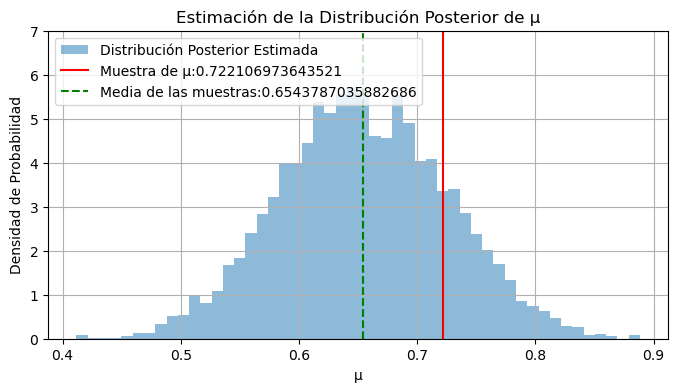

In [6]:
# Seleccionamos las muestras considerando "thinning" y "burn in"
burn_in = 0.2 # Se consideran las muestras a partir del 20% del total 
thinning = 10 # Se consideran samples cada 10 samples
# Seleccionamos las muestras
samples_extracted = accepted_samples[int(burn_in*cantidad_samples)::thinning]

# Generamos el gráfico para comparar los samples y el valor de mu
plt.figure(figsize=(8, 4))
plt.hist(samples_extracted, bins=50, density=True, alpha=0.5, label='Distribución Posterior Estimada')
plt.axvline(mu_sample, color='red', label=f'Muestra de \u03BC:{mu_sample}') 
plt.axvline(np.mean(samples_extracted),color='green', linestyle='--', label=f'Media de las muestras:{np.mean(samples_extracted)}')
plt.ylim(0, 7)
plt.xlabel('\u03BC')
plt.ylabel('Densidad de Probabilidad')
plt.title('Estimación de la Distribución Posterior de \u03BC')
plt.legend()
plt.grid(True)

# Muestra el gráfico
plt.show()

### e)
Se llevaron a cabo diversas pruebas para analizar cómo variaban las muestras generadas por el algoritmo de Metropolis-Hasting en función de la cantidad de muestras $n$ de las variables $x_{i}$. Se exploraron cuatro casos con $n=100, n=1000, n=10000$ y $n=30000$. Los resultados se presentan en los histogramas que se muestran a continuación. En general, se observa que a medida que se aumenta el número de muestras, el resultado del algoritmo tiende a desplazarse hacia una media cercana al valor de $\mu$ obtenido en la parte inicial del análisis (parte a). Sin embargo, es importante destacar que llega un punto en el que, al tener un número excesivamente grande de muestras, en este caso 30000, la distribución comienza a alejarse de este valor de referencia.

Este fenómeno sugiere que, si bien un aumento en la cantidad de muestras suele mejorar la convergencia del algoritmo hacia el valor deseado de $\mu$, alcanzar un número extremadamente elevado de muestras puede llevar a resultados menos precisos debido a factores como la autocorrelación. Por lo tanto, se puede desprender de este experimento que es esencial encontrar un equilibrio adecuado entre la eficiencia computacional y la precisión en las estimaciones al seleccionar el tamaño de la muestra en aplicaciones prácticas.

In [7]:
# Función para generar una cantidad dada de samples x_i
def get_samples(num_samples):
    samples = [norm.rvs(loc=mu_sample, scale=np.sqrt(varianza_xi)) for _ in range(num_samples)]
    return samples

In [8]:
# Fijamos la semilla
np.random.seed(206684402)

# Extraemos 4 cantidades de samples
samples_100 = get_samples(100)
samples_1000 = get_samples(1000)
samples_10000 = get_samples(10000)
samples_30000 = get_samples(30000)


# Parámetros del modelo
muestra_inicial = 0.1 # Muestra inicial donde inicia el algoritmo
cantidad_samples = 50000 # Cantidad de samples que se quieren generar
rango_dist_propuesto = 0.1 # Rango de la distribución uniforme para generar los samples propuestos

# Se ejecuta el algoritmo para los distintos casos
accepted_samples_100,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial, cantidad_samples, samples_100, rango_dist_propuesto)
accepted_samples_1000,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial, cantidad_samples, samples_1000, rango_dist_propuesto)
accepted_samples_10000,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial, cantidad_samples, samples_10000, rango_dist_propuesto)
accepted_samples_30000,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial, cantidad_samples, samples_30000, rango_dist_propuesto)

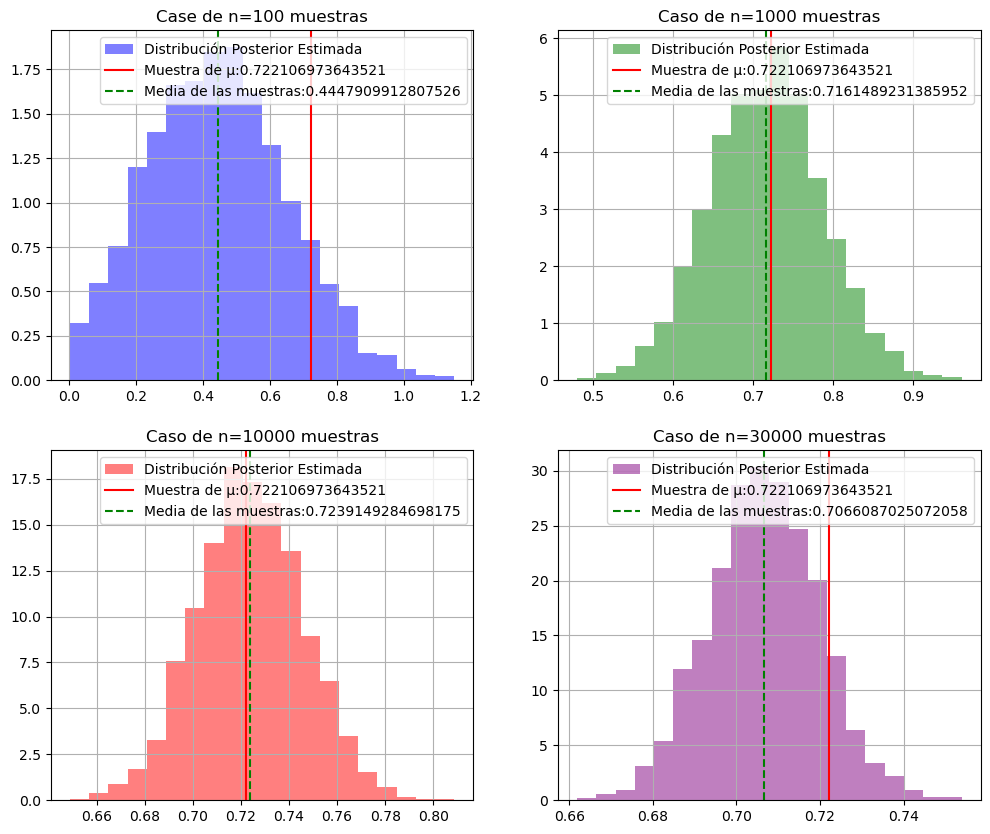

In [10]:
# Seleccionamos las muestras considerando "thinning" y "burn in"
burn_in = 0.2 # Se consideran las muestras a partir del 20% del total 
thinning = 10 # Se consideran samples cada 10 samples
# Seleccionamos las muestras
samples_extracted_100 = accepted_samples_100[int(burn_in*cantidad_samples)::thinning]
samples_extracted_1000 = accepted_samples_1000[int(burn_in*cantidad_samples)::thinning]
samples_extracted_10000 = accepted_samples_10000[int(burn_in*cantidad_samples)::thinning]
samples_extracted_30000 = accepted_samples_30000[int(burn_in*cantidad_samples)::thinning]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Trazar los histogramas en cada uno de los subplots
axs[0, 0].hist(samples_extracted_100, bins=20, density=True, color='blue', alpha=0.5, label='Distribución Posterior Estimada')
axs[0, 0].axvline(mu_sample, color='red', label=f'Muestra de \u03BC:{mu_sample}')
axs[0, 0].axvline(np.mean(samples_extracted_100),color='green', linestyle='--', label=f'Media de las muestras:{np.mean(samples_extracted_100)}')
axs[0, 0].set_title('Case de n=100 muestras')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].hist(samples_extracted_1000, bins=20, density=True, color='green', alpha=0.5, label='Distribución Posterior Estimada')
axs[0, 1].axvline(mu_sample, color='red', label=f'Muestra de \u03BC:{mu_sample}')
axs[0, 1].axvline(np.mean(samples_extracted_1000),color='green', linestyle='--', label=f'Media de las muestras:{np.mean(samples_extracted_1000)}')
axs[0, 1].set_title('Caso de n=1000 muestras')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].hist(samples_extracted_10000, bins=20, density=True, color='red', alpha=0.5, label='Distribución Posterior Estimada')
axs[1, 0].axvline(mu_sample, color='red', label=f'Muestra de \u03BC:{mu_sample}')
axs[1, 0].axvline(np.mean(samples_extracted_10000),color='green', linestyle='--', label=f'Media de las muestras:{np.mean(samples_extracted_10000)}')
axs[1, 0].set_title('Caso de n=10000 muestras')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].hist(samples_extracted_30000, bins=20, density=True, color='purple', alpha=0.5, label='Distribución Posterior Estimada')
axs[1, 1].axvline(mu_sample, color='red', label=f'Muestra de \u03BC:{mu_sample}')
axs[1, 1].axvline(np.mean(samples_extracted_30000),color='green', linestyle='--', label=f'Media de las muestras:{np.mean(samples_extracted_30000)}')
axs[1, 1].set_title('Caso de n=30000 muestras')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Mostrar el gráfico
plt.show()

### f)

Para esta sección, seguimos el mismo procedimiento que se describió anteriormente, pero esta vez implementamos un modelo de 3 componentes. Esto implicó generar 3 muestras de $\mu$ a partir de la distribución Half-normal, junto con 3 constantes $\lambda_{i}$ que actúan como ponderadores en la distribución de probabilidad de las muestras $x_{i}$. La distribución resultante se expresa de la siguiente manera:
$$x_{i} \sim \sum_{i=1}^{3}\lambda_{i}\mathcal{N}(\mu_{i}, 5))$$
Los ponderadores $\lambda_{i}$ se definieron como constantes y se generaron a partir de una distribución uniforme, asegurando que la probabilidad de todas las $\lambda_{i}$ sea siempre igual a 1. Esto permitió construir un modelo de mezcla de 3 componentes para describir la distribución de las muestras $x_{i}$.

In [11]:
# Fijamos la semilla
np.random.seed(206684402)

# Definimos a la variable μ 

# Parámetros de la distribución
mu_media = 0
mu_varianza = 10

# Generamos muestras de μ
mu_samples = halfnorm.rvs(scale=np.sqrt(mu_varianza), loc=mu_media, size=3)

# Definimos a la variable λ 

# Parámetros de la distribución
lambda_media = 0
lambda_varianza = 5

# Generamos muestras de λ 
lambda_samples = uniform.rvs(scale=np.sqrt(lambda_varianza), loc=lambda_media, size=3)

print(f"Las muestras generadas para λ son:{lambda_samples}")
print(f"Las muestras generadas para μ son:{mu_samples}")


Las muestras generadas para λ son:[0.46301476 1.13917028 0.16868874]
Las muestras generadas para μ son:[0.72210697 5.32717147 0.22065752]


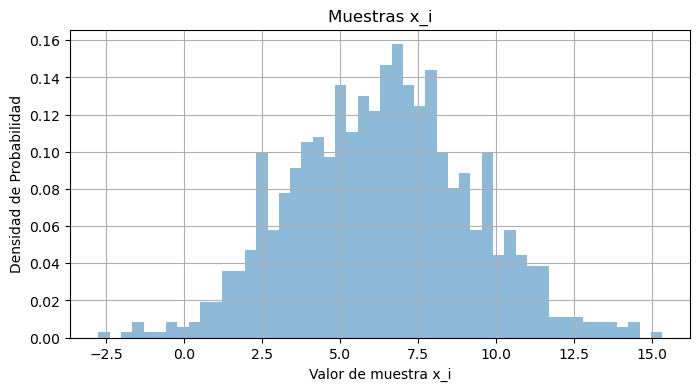

Media:6.353/Desviación Estándar:2.859


In [12]:
# Fijamos la semilla
np.random.seed(206684402)

# Parámetros de la distribución 
xi_varianza = 5
n_samples = 1000

# Generamos n muestras x_i 
xi_samples = np.array([np.sum(lambda_samples*norm.rvs(loc=mu_samples, scale=np.sqrt(xi_varianza))) for _ in range(n_samples)])

# Grafica las muestras x_i
plt.figure(figsize=(8, 4))
plt.hist(xi_samples, bins=50, density=True, alpha=0.5)
plt.xlabel('Valor de muestra x_i')
plt.ylabel('Densidad de Probabilidad')
plt.title('Muestras x_i')
plt.grid(True)

# # Muestra el gráfico
plt.show()
print(f"Media:{round(np.mean(xi_samples),3)}/Desviación Estándar:{round(np.std(xi_samples),3)}")

Para expresar $p(\mu|x_{1},...,x_{n})$ se utilizará el Teorema de Bayes, tal que:
$$p(\mu\lambda|x_{1},...,x_{n}) = \frac{p(x_{1},...,x_{n}|\mu\lambda)p(\mu\lambda)}{p(x_{1},...,x_{n})}$$
Además, en términos generales, se puede afirmar que calcular el denominador $p(x_{1},...,x_{n})$ es una tarea bastante compleja. Asimismo, se puede considerar que las muestras $x_{i}$ son independientes e idénticamente distribuidas (i.i.d.), y que los parámetros $\mu$ y $\lambda$ son mutuamente independientes. En consecuencia, la expresión de la distribución a posteriori puede ser formulada de la siguiente manera:
$$p(\mu\lambda|x_{1},...,x_{n}) \propto p(x_{1},...,x_{n}|\mu\lambda)p(\mu\lambda) = \prod_{i=1}^{n} p(x_{i}|\mu\lambda)p(\mu)p(\lambda) = \prod_{i=1}^{n} p(x_{i}|\mu)p(\mu)$$
Esta expresión se deriva considerando que los parámetros $\lambda_{i}$ son constantes fijas, lo que hace que la distribución a posteriori conjunta sea equivalente a la distribución a posteriori del parámetro $\mu$, dado que es el único que varía de acuerdo a una distribución de probabilidad. Además, el producto $\prod_{i=1}^{n} p(x_{i}|\mu)$ representa la función de verosimilitud en el caso en que las muestras son independientes e idénticamente distribuidas (i.i.d), mientras que $p(\mu)$ corresponde a la distribución a priori, la cual representa el conocimiento previo que se tiene sobre el parámetro $\mu$.


Para el diseño del algoritmo Metropolis-Hastings en este contexto específico, se siguió un procedimiento similar al descrito previamente. Se desarrolló una función que calcula la transformación logarítmica de la función prior, que representa el conocimiento previo sobre el parámetro $\mu$. Además, se diseñó una función que realiza la transformación logarítmica de la función likelihood utilizando los datos obtenidos de las muestras $x_{i}$, junto con los valores de $\mu$ y $\lambda$.

Luego, se implementó el algoritmo de Metropolis-Hastings, el cual conserva una estructura similar a la función diseñada anteriormente, con la principal diferencia de que en este caso debe generar tres muestras para el parámetro $\mu$, uno para cada componente del modelo. En resumen, el algoritmo Metropolis-Hastings se ajustó para generar muestras para los tres $\mu$ correspondientes a las tres componentes del modelo.

In [13]:
# Función de logaritmo de la distribución prior
def log_prior(u):
    assert type(u) == np.ndarray
    if np.any(u<0):
        return -np.inf # Si alguno de los mu propuestos son negativos se rechaza
    return 0 # Si todos los valores de mu son positivos se aceptan

# Función de logaritmo de la distribución likelihood
def log_likelihood(mu, lambda_values, data):
    # Se calcula la densidad de probabilidad para cada dato con todas las medias mu_i
    pdf_values = norm.pdf(data[:, np.newaxis], loc=mu, scale=np.sqrt(5))
    
    # Se calcula la suma ponderada para cada dato
    weighted_sum = np.sum(lambda_values * pdf_values, axis=1)
    
    # Se calcula la log-verosimilitud sumando los logaritmos de las sumas ponderadas
    log_likelihood = np.sum(np.log(weighted_sum))
    
    return log_likelihood


# Se define la función que realiza el algoritmo de Metropolis-Hasting
def metropolis_hasting(likelihood, prior, sample_init, lambda_values, num_samples, data, rango_propuesto):
    
    # Se registran los samples que fueron aceptados y rechazados
    accepted_samples = [sample_init] # Se asigna el sample inicial como el primer aceptado
    rejected_samples = [] 
    
    for i in range(num_samples):
        # Se genera un sample de mu propuesto a partir de una distribución normal
        u_proposed = np.random.normal(scale=rango_propuesto, loc=accepted_samples[-1])
        
        # Se genera el ratio de aceptación aplicando la transformación logarítmica
        ratio_acceptance = (likelihood(u_proposed, lambda_values, data) + prior(u_proposed))-(likelihood(accepted_samples[-1], lambda_values, data) + prior(accepted_samples[-1]))
        
        # Si el valor del ratio es mayor a un valor aleatorio entre 0 y 1 se acepta el sample
        if np.log(np.random.rand()) < ratio_acceptance:
            accepted_samples.append(u_proposed) # Se registra en la lista de samples aceptados
        # Si el valor del ratio no es mayor al valor aleatorio se rechaza el sample
        else:
            accepted_samples.append(accepted_samples[-1]) # Se registra el sample actual nuevamente
            rejected_samples.append(u_proposed) # Se registra el sample rechazado en la lista de samples rechazados
            
    return accepted_samples, rejected_samples  

In [14]:
# Fijamos la semilla
np.random.seed(206684402)

# Parámetros del modelo
muestra_inicial_mu = mu_samples
lambda_values = lambda_samples
cantidad_samples = 50000
rango_dist_propuesto = 0.1 

# Se ejecuta el algoritmo
accepted_samples_mu,rejected_samples_mu= metropolis_hasting(log_likelihood, log_prior, muestra_inicial_mu, lambda_values, cantidad_samples, xi_samples, rango_dist_propuesto)

In [15]:
# Función para extraer los valores de cada parámetri u_i dentro de los arrays que conforman el array de resultado
# en el algoritmo Metropolis Hasting
def mu_extract(mu_samples_mh, indice):
    mu = []
    for element in mu_samples_mh:
        mu.append(element[indice])
    return mu

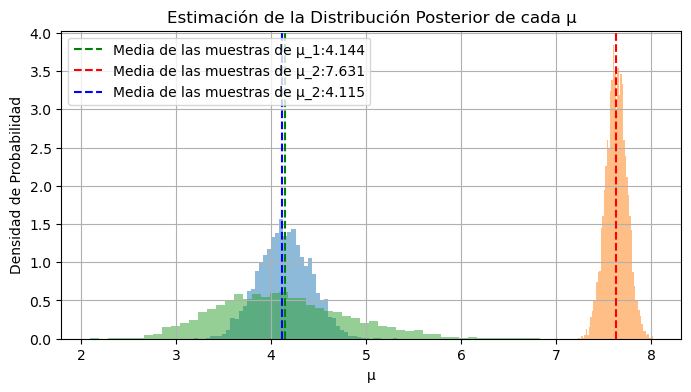

In [16]:
# Seleccionamos las muestras considerando "thinning" y "burn in"
burn_in = 0.2 # Se consideran las muestras a partir del 20% del total 
thinning = 10 # Se consideran samples cada 10 samples
# Seleccionamos las muestras para cada u_i
samples_extracted_u_1 = mu_extract(accepted_samples_mu, 0)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_u_2 = mu_extract(accepted_samples_mu, 1)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_u_3 = mu_extract(accepted_samples_mu, 2)[int(burn_in*cantidad_samples)::thinning]


# Graficamos los samples obtenidos para cada parámetro
plt.figure(figsize=(8, 4))
plt.hist(samples_extracted_u_1, bins=50, density=True, alpha=0.5)
plt.axvline(np.mean(samples_extracted_u_1),color='green', linestyle='--', label=f'Media de las muestras de μ_1:{round(np.mean(samples_extracted_u_1), 3)}')

plt.hist(samples_extracted_u_2, bins=50, density=True, alpha=0.5)
plt.axvline(np.mean(samples_extracted_u_2),color='red', linestyle='--', label=f'Media de las muestras de μ_2:{round(np.mean(samples_extracted_u_2), 3)}')

plt.hist(samples_extracted_u_3, bins=50, density=True, alpha=0.5)
plt.axvline(np.mean(samples_extracted_u_3),color='blue', linestyle='--', label=f'Media de las muestras de μ_2:{round(np.mean(samples_extracted_u_3), 3)}')
plt.xlabel('\u03BC')
plt.ylabel('Densidad de Probabilidad')
plt.title('Estimación de la Distribución Posterior de cada \u03BC')
plt.legend()
plt.grid(True)

# # Muestra el gráfico
plt.show()

In [17]:
# Función para generar una cantidad dada de samples x_i
def get_samples_mult(num_samples):
    samples = np.array([np.sum(lambda_samples*norm.rvs(loc=mu_samples, scale=np.sqrt(xi_varianza))) for _ in range(num_samples)])
    return samples

In [18]:
# Fijamos la semilla
np.random.seed(206684402)

# Extraemos 4 cantidades de samples
samples_mult_100 = get_samples_mult(100)
samples_mult_1000 = get_samples_mult(1000)
samples_mult_10000 = get_samples_mult(10000)
samples_mult_30000 = get_samples_mult(30000)


# Parámetros del modelo
muestra_inicial_mu = mu_samples
lambda_values = lambda_samples
cantidad_samples = 50000
rango_dist_propuesto = 0.1 

# Se ejecuta el algoritmo para los distintos casos
accepted_samples_mu_100,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial_mu, lambda_values, cantidad_samples, samples_mult_100, rango_dist_propuesto)
accepted_samples_mu_1000,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial_mu, lambda_values, cantidad_samples, samples_mult_1000, rango_dist_propuesto)
accepted_samples_mu_10000,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial_mu, lambda_values, cantidad_samples, samples_mult_10000, rango_dist_propuesto)
accepted_samples_mu_30000,_ = metropolis_hasting(log_likelihood, log_prior, muestra_inicial_mu, lambda_values, cantidad_samples, samples_mult_30000, rango_dist_propuesto)

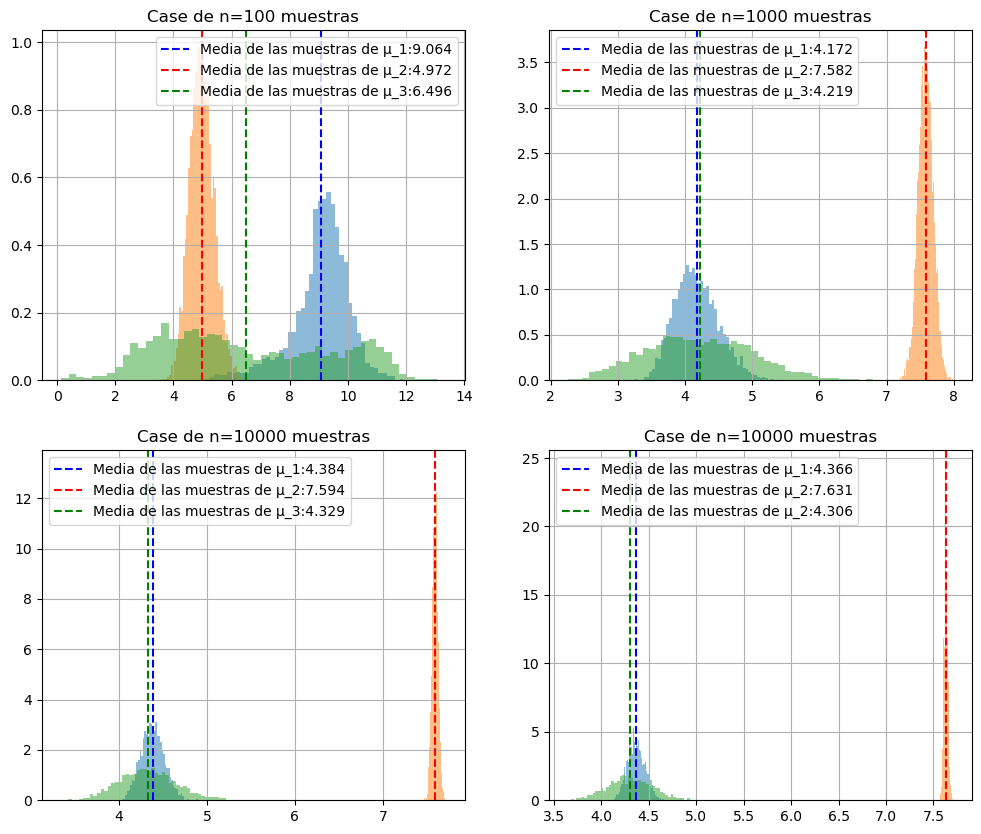

In [19]:
# Seleccionamos las muestras considerando "thinning" y "burn in"
burn_in = 0.2 # Se consideran las muestras a partir del 20% del total 
thinning = 10 # Se consideran samples cada 10 samples
# Seleccionamos las muestras
samples_extracted_100_u_1 = mu_extract(accepted_samples_mu_100, 0)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_100_u_2 = mu_extract(accepted_samples_mu_100, 1)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_100_u_3 = mu_extract(accepted_samples_mu_100, 2)[int(burn_in*cantidad_samples)::thinning]

samples_extracted_1000_u_1 = mu_extract(accepted_samples_mu_1000, 0)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_1000_u_2 = mu_extract(accepted_samples_mu_1000, 1)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_1000_u_3 = mu_extract(accepted_samples_mu_1000, 2)[int(burn_in*cantidad_samples)::thinning]

samples_extracted_10000_u_1 = mu_extract(accepted_samples_mu_10000, 0)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_10000_u_2 = mu_extract(accepted_samples_mu_10000, 1)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_10000_u_3 = mu_extract(accepted_samples_mu_10000, 2)[int(burn_in*cantidad_samples)::thinning]

samples_extracted_30000_u_1 = mu_extract(accepted_samples_mu_30000, 0)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_30000_u_2 = mu_extract(accepted_samples_mu_30000, 1)[int(burn_in*cantidad_samples)::thinning]
samples_extracted_30000_u_3 = mu_extract(accepted_samples_mu_30000, 2)[int(burn_in*cantidad_samples)::thinning]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Trazar los histogramas en cada uno de los subplots

axs[0, 0].hist(samples_extracted_100_u_1, bins=50, density=True, alpha=0.5)
axs[0, 0].axvline(np.mean(samples_extracted_100_u_1),color='blue', linestyle='--', label=f'Media de las muestras de μ_1:{round(np.mean(samples_extracted_100_u_1), 3)}')
axs[0, 0].hist(samples_extracted_100_u_2, bins=50, density=True, alpha=0.5)
axs[0, 0].axvline(np.mean(samples_extracted_100_u_2),color='red', linestyle='--', label=f'Media de las muestras de μ_2:{round(np.mean(samples_extracted_100_u_2), 3)}')
axs[0, 0].hist(samples_extracted_100_u_3, bins=50, density=True, alpha=0.5)
axs[0, 0].axvline(np.mean(samples_extracted_100_u_3),color='green', linestyle='--', label=f'Media de las muestras de μ_3:{round(np.mean(samples_extracted_100_u_3), 3)}')
axs[0, 0].set_title('Case de n=100 muestras')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].hist(samples_extracted_1000_u_1, bins=50, density=True, alpha=0.5)
axs[0, 1].axvline(np.mean(samples_extracted_1000_u_1 ),color='blue', linestyle='--', label=f'Media de las muestras de μ_1:{round(np.mean(samples_extracted_1000_u_1 ), 3)}')
axs[0, 1].hist(samples_extracted_1000_u_2, bins=50, density=True, alpha=0.5)
axs[0, 1].axvline(np.mean(samples_extracted_1000_u_2),color='red', linestyle='--', label=f'Media de las muestras de μ_2:{round(np.mean(samples_extracted_1000_u_2), 3)}')
axs[0, 1].hist(samples_extracted_1000_u_3, bins=50, density=True, alpha=0.5)
axs[0, 1].axvline(np.mean(samples_extracted_1000_u_3),color='green', linestyle='--', label=f'Media de las muestras de μ_3:{round(np.mean(samples_extracted_1000_u_3), 3)}')
axs[0, 1].set_title('Case de n=1000 muestras')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].hist(samples_extracted_10000_u_1, bins=50, density=True, alpha=0.5)
axs[1, 0].axvline(np.mean(samples_extracted_10000_u_1),color='blue', linestyle='--', label=f'Media de las muestras de μ_1:{round(np.mean(samples_extracted_10000_u_1), 3)}')
axs[1, 0].hist(samples_extracted_10000_u_2, bins=50, density=True, alpha=0.5)
axs[1, 0].axvline(np.mean(samples_extracted_10000_u_2),color='red', linestyle='--', label=f'Media de las muestras de μ_2:{round(np.mean(samples_extracted_10000_u_2), 3)}')
axs[1, 0].hist(samples_extracted_10000_u_3, bins=50, density=True, alpha=0.5)
axs[1, 0].axvline(np.mean(samples_extracted_10000_u_3),color='green', linestyle='--', label=f'Media de las muestras de μ_3:{round(np.mean(samples_extracted_10000_u_3), 3)}')
axs[1, 0].set_title('Case de n=10000 muestras')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].hist(samples_extracted_30000_u_1, bins=50, density=True, alpha=0.5)
axs[1, 1].axvline(np.mean(samples_extracted_30000_u_1),color='blue', linestyle='--', label=f'Media de las muestras de μ_1:{round(np.mean(samples_extracted_30000_u_1), 3)}')
axs[1, 1].hist(samples_extracted_30000_u_2, bins=50, density=True, alpha=0.5)
axs[1, 1].axvline(np.mean(samples_extracted_30000_u_2),color='red', linestyle='--', label=f'Media de las muestras de μ_2:{round(np.mean(samples_extracted_30000_u_2), 3)}')
axs[1, 1].hist(samples_extracted_30000_u_3, bins=50, density=True, alpha=0.5)
axs[1, 1].axvline(np.mean(samples_extracted_30000_u_3),color='green', linestyle='--', label=f'Media de las muestras de μ_2:{round(np.mean(samples_extracted_30000_u_3), 3)}')
axs[1, 1].set_title('Case de n=10000 muestras')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Mostrar el gráfico
plt.show()

Los resultados anteriores proporcionan una visión intrigante del comportamiento del modelo de mezcla de tres componentes. En particular, se observa que los tres parámetros $\mu$ se concentran en diferentes regiones. Es interesante notar que, a pesar de que las muestras correspondientes a $\mu_{1}$ y $\mu_{3}$ convergen hacia valores medios similares, estas últimas exhiben una mayor dispersión o varianza. 

Además, se destaca que a medida que el número de muestras $x_{i}$ aumenta, la convergencia de las muestras mejora significativamente. Inicialmente, con pocas muestras, estas presentan una dispersión considerable, pero a medida que se incrementa la cantidad de muestras, tienden a agruparse en regiones más definidas. Este comportamiento refleja la influencia del tamaño de la muestra en la precisión de las estimaciones.

Por último, es relevante notar que ninguno de los tres conjuntos de muestras converge a los valores de $\mu$ obtenidos inicialmente. Esto podría atribuirse en gran medida a la construcción de la distribución de las muestras $x_{i}$. Dicha distribución es el resultado de una suma ponderada de distribuciones normales, cuyas medias están determinadas por las muestras de $\mu$. Es posible que esta ponderación, a través de los ponderadores $\lambda_{i}$, haya influido en la convergencia de las muestras de $\mu$ de manera no trivial. 

## P2 - Modelos Gráficos

### a)

En este problema, se está explorando la probabilidad de tener Rinitis alérgica y las variables e influencias que pueden contribuir a esta condición. Para esto, las hipótesis que se consideraron fueron las siguientes:

- La predisposición genética puede influir directamente en la probabilidad de tener Rinitis alérgica.
- La presencia de Rinitis alérgica puede estar directamente relacionada con la probabilidad de experimentar irritación en los ojos y la nariz, ya que estos síntomas son manifestaciones comunes de esta enfermedad.
- La cantidad de polen en el entorno puede desencadenar irritación en los ojos y la nariz, pero no determina directamente si alguien padece Rinitis alérgica. No obstante, si alguien ya tiene Rinitis alérgica y se encuentra en un entorno con una alta concentración de polen, es altamente probable que experimente irritación en los ojos y la nariz como consecuencia.

A partir de estas hipótesis se puede proceder con la descripción de las variables del modelo y como se relacionan entre ellas.

**Variables:**
- **Tener un familiar con Rinitis alérgica:** Variable que indica si la persona tiene un familiar con Rinitis alérgica. Esta variable representa la predisposición genética a la enfermedad. Se considerará que no lo sabemos.

- **Tener o no Rinitis alérgica:** Variable que indica si alguien tiene Rinitis alérgica. Esta es la variable que queremos determinar.

- **Irritación en nariz y ojos:** Variable que describe si una persona experimenta irritación en los ojos y la nariz. Esta variable refleja los síntomas y consecuencias de la Rinitis alérgica.

- **Cantidad de polen en el ambiente:** Variable que representa la cantidad de polen en el ambiente en un momento dado. Esta variable puede provocar la irritación en los ojos y la nariz.

Para comenzar este problema, se considerará que cada variable es binaria, lo que significa que, por ejemplo, la variable 'Cantidad de polen en el ambiente' tendrá un valor de 0 cuando la concentración de polen en el ambiente sea baja y un valor de 1 cuando sea alta.

Por último, se pueden plantear las relaciones y dependencias entre cada una de las variables anteriores.

**Dependencias entre variables**

Primero que todo, la variable "Tener un familiar con Rinitis alérgica" influye directamente en la variable "Tener o no Rinitis alérgica", ya que la predisposición genética puede aumentar la probabilidad de tener Rinitis alérgica.

Segundo, la variable "Tener o no Rinitis alérgica" influye directamente en la variable "Irritación en nariz y ojos", ya que tener Rinitis alérgica puede aumentar la probabilidad de experimentar irritación en los ojos y la nariz debido a que es uno de sus síntomas.

Tercero, la variable "Cantidad de polen en el ambiente" influye directamente en la variable "Irritación en nariz y ojos", ya que la cantidad de polen en el ambiente puede provocar irritación en los ojos y la nariz. 

Por otra parte, no hay una relación directa entre las variables "Cantidad de polen en el ambiente" y "Tener o no Rinitis alérgica", ya que se consideró que la cantidad de polen en el ambiente no afecta directamente a la probabilidad de tener Rinitis alérgica. Sin embargo, ambas variables pueden influir en la irritación en los ojos y la nariz, lo que sugiere una relación por medio de la variable "Irritación en nariz y ojos".

Finalmente, después de esta explicación detallada del modelo, se puede representar visualmente la estructura del mismo mediante un Grafo Acíclico Dirigido (DAG) en la siguiente figura.


<br>
<center>
<img src="./P2_a_DAG.jpg" width=500 height=500 alt="Representación de una imagen" />
</center>
<br>

Para seguir desarrollando esta parte se considerará que se conocen las probabilidades condicionales que conforman a la distribución conjunta del modelo, el cual tiene la siguiente forma:
$$P(\text{Familiar, Rinitis, Polen, Irritación}) = P(\text{Irritación}|\text{Rinitis, Polen})\cdot P(\text{Rinitis}|\text{Familiar})\cdot P(\text{Familiar})\cdot P(\text{Polen}) $$

### b)

La probabilidad de tener *Rinitis alérgica*, es decir que la variable "Tener o no Rinitis alérgica" es 1, dado que la persona presenta irritación de nariz y ojos, es decir que la variable "Irritación en nariz y ojos", se puede expresar utilizando el Teorema de Bayes, tal que:
$$P(\text{Rinitis} = 1|\text{Irritación} = 1) = \frac{P(\text{Irritación} = 1|\text{Rinitis} = 1)\cdot P(\text{Rinitis} = 1)}{P(\text{Irritación} = 1)}$$

- $P(\text{Irritación} = 1|\text{Rinitis} = 1)$ consiste en la función likelihood, la cual representa la probabilidad de tener irritación de nariz y ojos condicional a tener Rinitis alérgica. Esta expresión se puede seguir dearrollando involucrando a las demás dependencias entre las variables, tal que:
$$P(\text{Irritación} = 1|\text{Rinitis} = 1) = \sum_{\text{Polen} \in \{0,1\}}P(\text{Rinitis} = 1)\cdot P(Polen)\cdot P(\text{Irritación} = 1|\text{Rinitis} = 1, \text{Polen})$$

- $P(\text{Rinitis} = 1)$ consiste en la función prior de la variable "Tener o no Rinits alérgica", la cual representa la probabilidad de tener Rinitis alérgica. Esta expresión se puede seguir desarrollando involucrando a las demás dependencias entre las variables, tal que:
$$P(\text{Rinitis} = 1) = \sum_{\text{Familiar} \in \{0,1\}}P(\text{Rinitis} = 1|\text{Familiar})\cdot P(\text{Familiar})$$

- $P(\text{Irritación} = 1)$ consiste en la probabilidad de tener irritación en la nariz y ojos. Esta expresión se puede seguir desarrollando involucrando a las demás dependencias entre las variables, tal que:
$$P(\text{Irritación} = 1) = \sum_{\text{Familiar, Rinitis, Polen} \in \{0,1\}}P(\text{Irritación} = 1|\text{Rinitis, Polen})\cdot P(\text{Rinitis}|\text{Familiar})\cdot P(\text{Polen})\cdot P(\text{Familiar})$$

### c)

En este problema se debe incorporar el resultado de un test de *Frotis Nasal*, el cual tiene como resultados *postivo* o 1 y *negativo* o 0. Para incorporar el resultado del test en la probabilidad de tener o no Rinitis alérgica se formularán algunas hipótesis:

- El resultado del test de Frotis Nasal(Test) entrega información y depende directamente de si el individuo tiene rinitis o no. Es decir que el único padre de esta variable en la variable "Tener o no Rinitis alérgica", lo cual significa que "Test" puede ser positivo(Test=1) con mayor probabilidad si la persona tiene rinitis(Rinitis=1) y menos probable si no tiene rinitis(Rinitis=0).

A partir de la incorporación de esta nueva variable, nuestro modelo tipo DAG del problema se puede representar como en la figura siguiente:

<br>
<center>
<img src="./P2_c_DAG.jpg" width=500 height=500 alt="Representación de una imagen" />
</center>
<br>

Asimismo, nuestra función de probabilidad conjunta del modelo también se ve modificada debido a la incorporación de esta nueva variable, tal que:

$$P(\text{Familiar, Rinitis, Polen, Test, Irritación}) = P(\text{Irritación}|\text{Rinitis, Polen})\cdot P(\text{Test}|\text{Rinitis})\cdot P(\text{Rinitis}|\text{Familiar})\cdot P(\text{Familiar})\cdot P(\text{Polen}) $$

Una vez definida la nueva estructura del modelo, se puede definir la probabilidad de tener o no Rinitis dado que se tiene irritación de nariz y ojos, incorporando la nueva variable de test, de la siguiente manera:

$$P(\text{Rinitis} = 1|\text{Irritación} = 1) = \frac{P(\text{Rinitis} = 1, \text{Irritación} = 1)}{P(\text{Irritación} = 1)} = \frac{\sum_{\text{Familiar, Polen, Test} \in \{0,1\}}P(\text{Irritación} = 1|\text{Rinitis} = 1,\text{Polen})\cdot P(\text{Rinitis} = 1|\text{Familiar})\cdot P(\text{Test}|\text{Rinitis} = 1)\cdot P(\text{Polen})\cdot P(\text{Familiar})}{P(\text{Irritación} = 1)} $$

Donde $P(\text{Irritación} = 1)$ representa la probabilidad de tener irritación en ojos y nariz. Esta probabilidad se puede desarrollar incorporando las demás variables y dependencias entre ellas, tal que:

$$P(\text{Irritación} = 1) = \sum_{\text{Familiar}\in \{0,1\}}\sum_{\text{Test}\in \{0,1\}}\sum_{\text{Rinitis}\in \{0,1\}}\sum_{\text{Polen}\in \{0,1\}}P(\text{Familiar, Rinitis, Polen, Test, Irritación = 1})\\ = \sum_{\text{Familiar}\in \{0,1\}}\sum_{\text{Test}\in \{0,1\}}\sum_{\text{Rinitis}\in \{0,1\}}\sum_{\text{Polen}\in \{0,1\}}P(\text{Irritación} = 1|\text{Rinitis, Polen})\cdot P(\text{Test}|\text{Rinitis})\cdot P(\text{Rinitis}|\text{Familiar})\cdot P(\text{Familiar})\cdot P(\text{Polen}) $$

Esta función se puede reescribir para optimizar su proceso computacional utilizando *Variable elimination*, tal que:

$$P(\text{Irritación} = 1) = \sum_{\text{Familiar}\in \{0,1\}} P(\text{Familiar})\cdot T_{3}(\text{Irritación = 1, Familiar})$$

- $T_{3}(\text{Irritación = 1, Familiar}) = \sum_{\text{Rinitis}\in \{0,1\}}P(\text{Rinitis}|\text{Familiar})\cdot T_{2}(\text{Irritación = 1, Rinitis})$

- $T_{2}(\text{Irritación = 1, Rinitis}) = \sum_{\text{Test}\in \{0,1\}}P(\text{Test}|\text{Rinitis})\cdot T_{1}(\text{Rinitis, Irritación = 1}) $

- $T_{1}(\text{Rinitis, Irritación = 1}) = \sum_{\text{Polen}\in \{0,1\}}P(\text{Polen})\cdot P(\text{Irritación = 1}|\text{Rinitis, Polen})$

### (Bonus)

En este problema, se está considerando que la cantidad de polen en el ambiente, representada como $Y_{polen}$, sigue una distribución "semi normal" o Half-normal, donde $Y_{polen} = |X|$, con X una variable aleatoria que distribuye según $N(0, \sigma^{2})$.

La distribución "semi normal" es un caso particular de la distribución normal que toma solo los valores no negativos debido al valor absoluto |X|. Esto implica que existe una gran probabilidad a tener valores bajos de niveles de polen en el ambiente, la cual disminuye a medida que los niveles aumentan.

Comparado con el modelo anterior, donde se consideraba una variable discreta y binaria para "Polen," esta representación continua de la cantidad de polen permite una mayor flexibilidad para el modelamiento del problema. En el modelo anterior, se asumía que la cantidad de polen era alta o baja(1 o 0), mientras que el modelo actual es más realista al tratar la cantidad de polen como una variable continua. Esto permite capturar la variabilidad en la concentración de polen de manera más precisa y realista.

En el modelo anterior, se simplificó la relación entre el polen y los síntomas de la Rinitis alérgica, como la irritación de nariz y ojos, al tratarla como una variable binaria, lo que puede no reflejar con precisión la verdadera influencia del polen en estos síntomas. Ahora, con una representación continua de la cantidad de polen, se puede modelar con mayor detalle cómo los niveles de polen pueden afectar la probabilidad de experimentar síntomas de irritación en nariz y ojos y, por lo tanto, la probabilidad de tener Rinitis alérgica.


### e)

Asumiendo que se tiene Rinitis alérgica(Rinitis = 1) ahora interesa modelar la cantidad de polen en ambiente para predecir altos niveles y prepararse ante el malestar. Para esto se pide diseñar el problema tal que se pueda predecir la cantidad de polen cada 30 minutos, siendo la única medición, el nivel de irritación de la nariz y ojos. Se pide asumir que el futuro es independiente del pasado, dado el presente, lo cual es la idea principal de los *Hidden Markov Models*.

Para plantear le problema de predicción definiremos las siguientes variables:
- **Cantidad de polen en el ambiente($P_{t}$):** Variable que se quiere predecir. Representa la concentración de polen en el ambiente en un momento dado t. Estos serán los estados ocultos del *Hidden Markon Model*, estos podrían tener, por ejemplo, valores o estados discretos que representen los distintos niveles de concentración de polen, como bajo, alto , medio, etc. y también pueden tener valores continuos, como en la parte anterior, y distribuir mediante alguna distribución continua, com ola Half-normal.

- **Nivel de irritación de nariz y ojos($I_{t}$):** Variable que representa el nivel de irritación de nariz y ojos, se utiliza como medición de la cantidad de polen en el ambiente. Estas serán las variable visibles de modelo y cada una estará asociada con un estado oculto en un momento dado.

Entre cada estado oculto habrá una transición que representará la variación de la concentración de polen en el ambiente en función del tiempo, tal que para este problema en particular, cada transición en el tiempo será de 30 minutos. Por otra parte, por la definición del modelo se sabe que el futuro es condicionalmente independiente de pasado, dado el presente, lo cual se puede traducir a que $P_{t-1}\perp\!\!\!\perp P_{t+1}|P_{t}$. De esta forma para formular el problema se debe definir una función prior, es decir una función de probabilidad del primer estado oculto, $P(P_{1} = i)$, una matriz de transición $M_{ij} = P(P_{t+1} = j|P_{t} = i)$ y por último, la relación que existe entre nuestras variables observables y nuestras variables ocultas, $P(I_{t} = y|P_{t} = i)$, de tal forma que se pueda definir la distribución conjunta del modelo de la siguiente forma:
$$P(P,I) = P(P_{1})P(I_{1}|P_{1})\prod_{t=2}^{n}P(P_{t}|P_{t-1})P(I_{t}|P_{t})$$

donde n es la cantidad total de transiciones. Este modelo se puede representar en la figura siguiente:

<br>
<center>
<img src="./P2_e_HMM.jpg" width=500 height=400 alt="Representación de una imagen" />
</center>
<br>

## P3 - Introducción al Transporte Óptimo

### a)

En este problema se busca encontrar un método donde se pueda resolver el siguiente problema de optimización lineal, cuyo objetivo es encontrar la matriz de asignación con la cual se pueda realizar un transporte óptimo entre las distribuciones $\alpha = \sum_{i=1}^{n}a_{i}\delta_{x_{i}}$ y $\beta = \sum_{j=1}^{m}b_{j}\delta_{y_{j}}$:

 $$P* \in argmin_{P \in U(a,b)}\sum_{i,j}P_{i,j}C_{i,j}$$ 
 Donde $U(a,b) = \{P \in R_{+}^{n x m}, \forall_{i} \sum_{j}P_{i,j}=a_{i}, \forall_{j} \sum_{i}P_{i,j} = b_{j}\}$ y $C_{j} = ||x_{i}-y_{j}||^2$

 Para esto se hizo uso de la librería PuLP(Python Linear Programming Library), la cual es una biblioteca de Python que facilita la formulación y resolución de problemas de programación lineal y mixta-integer programming(MIP). Él código implementado se puede observar a continuación

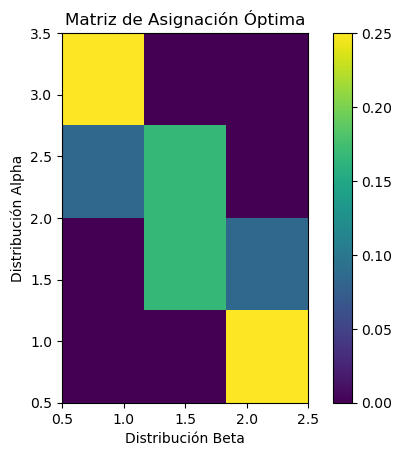

Valor óptimo de la función objetivo: 12.500000075


In [7]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

# Definimos los datos del problema
n = 4  # Tamaño de la distribución alpha
m = 3  # Tamaño de la distribución beta

# Definimos algunas ubicaciones en las distribuciones alpha y beta
x = [1, 2, 3, 4]
y = [5, 6, 7]

# Definimos la función de costo como la distancia euclidiana al cuadrado
cost_matrix = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        cost_matrix[i, j] = (x[i] - y[j]) ** 2

# Se crear el problema de optimización
problema = pulp.LpProblem("Problema_Transporte_Optimo", pulp.LpMinimize)

# Se define la matriz de variables de decisión
P = pulp.LpVariable.dicts("P", [(i, j) for i in range(n) for j in range(m)], lowBound=0, cat='Continuous')

# Se define la función objetivo
problema += pulp.lpSum(P[i, j] * cost_matrix[i][j] for i in range(n) for j in range(m)), "Función_Objetivo"

# Definimos las restricciones de sumas de filas y columnas
for i in range(n):
    problema += pulp.lpSum(P[i, j] for j in range(m)) == 1 / n, f"Restricción_Fila_{i + 1}"

for j in range(m):
    problema += pulp.lpSum(P[i, j] for i in range(n)) == 1 / m, f"Restricción_Columna_{j + 1}"

# Resolvemos el problema
problema.solve()

# Construimos y visualizamos la matriz de asignación óptima
if pulp.LpStatus[problema.status] == "Optimal":
    matriz_asignacion_optima = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            matriz_asignacion_optima[i, j] = P[i, j].varValue

    # Visualizar la matriz de asignación óptima
    plt.imshow(matriz_asignacion_optima, cmap='viridis', origin='upper', extent=(0.5, m - 0.5, 0.5, n - 0.5))
    plt.colorbar()
    plt.title('Matriz de Asignación Óptima')
    plt.xlabel('Distribución Beta')
    plt.ylabel('Distribución Alpha')
    plt.show()
    print("Valor óptimo de la función objetivo:", pulp.value(problema.objective))
else:
    print("No se encontró una solución óptima.")


A partir del código implementado se obtuvo como resultado una matriz de asignación óptima, la cual indica mediante valores o pesos la cantidad de masa que fue transportada desde un punto $x_{i}$ de la distribución original, hasta otro punto $y_{j}$ de la distribución de destino. En la matriz obtenida se puede observar que el transporte de mayor masa ocurrió en los puntos de las esquinas y fue disminuyendo a lo largo de la diagonal, por otra parte, la forma de la matriz se debe principalmente a que se realizó un transporte de masa desde una distribución de mayor tamaño a una de menor tamaño.



### b)

### c)

### d)

### e)